In [4]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [5]:
client = bnb_client(tld='US')

def get_data(symbol,freq,start_ts = '2025-01-01',end_ts='2025-07-15'):
    data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data

In [6]:
universe = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'SOLUSDT', 'ADAUSDT', 
            'XRPUSDT', 'MATICUSDT', 'DOGEUSDT']
freq = '4h'


px = {}
volume = {}
for x in universe:
    data = get_data(x,freq)
    px[x] = data.set_index('open_time')['close']
    volume[x] = data.set_index('open_time')['volume']

px = pd.DataFrame(px).astype(float)
volume = pd.DataFrame(volume).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
volume = volume.reindex(pd.date_range(volume.index[0],volume.index[-1],freq=freq))
ret = px.pct_change()
volume

/var/folders/3x/xn7ybzts4bj7ldmz08flw7lh0000gn/T/ipykernel_9871/67391828.py:4: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  data = client.get_historical_klines(symbol,freq,start_ts,end_ts)
/var/folders/3x/xn7ybzts4bj7ldmz08flw7lh0000gn/T/ipykernel_9871/67391828.py:11: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
/var/folders/3x/xn7ybzts4bj7ldmz08flw7lh0000gn/T/ipykernel_9871/67391828.py:12: Depre

,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,ADAUSDT,XRPUSDT,MATICUSDT,DOGEUSDT
2025-01-01 00:00:00,4.37650,22.7499,135.223,666.849,49058.1,178443.0,48130.1,205817.0
2025-01-01 04:00:00,3.15939,44.5188,79.355,788.213,71568.6,263170.0,11977.8,1272075.0
2025-01-01 08:00:00,4.12287,16.3808,37.121,2648.497,31659.4,106685.0,1714.4,142064.0
2025-01-01 12:00:00,0.43420,9.6214,49.511,210.931,106807.6,151917.0,11550.7,1275147.0
2025-01-01 16:00:00,2.80482,36.5767,26.357,277.187,467601.2,210849.0,15609.0,139372.0
...,...,...,...,...,...,...,...,...
2025-07-14 08:00:00,1.10127,46.2050,34.631,222.791,219837.9,224366.3,NaN,50280.0
2025-07-14 12:00:00,4.37419,109.2381,51.147,587.941,60258.3,257938.4,NaN,562866.0
2025-07-14 16:00:00,2.43825,77.2442,42.304,293.355,96807.2,90783.6,NaN,402737.0
2025-07-14 20:00:00,1.45580,51.7580,21.336,227.120,124603.7,210954.8,NaN,126483.0


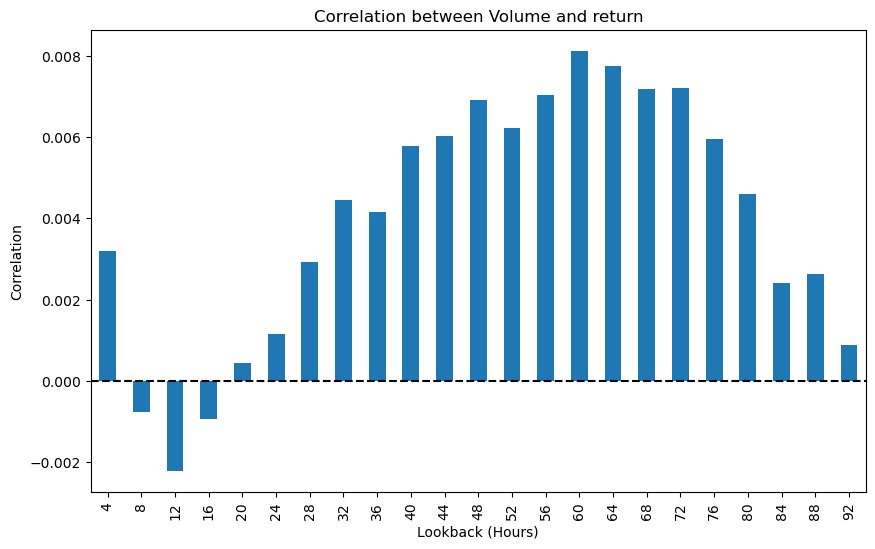

In [7]:
allvol = {}

periods = range(1,24)

for p in periods:
    
    window = volume.rolling(p).mean()
    nextReturn = ret.shift(-1)
    
    # Find valid periods where a nextReturn is found
    valid = window.stack().dropna().index.intersection(nextReturn.stack().dropna().index)
    
    window = window.stack().loc[valid]
    nextReturn = nextReturn.stack().loc[valid]
    
    # Calculate correlation between window and the next 4 hours
    corr = window.corr(nextReturn)
    allvol[p*4] = corr 
    
pd.Series(allvol).plot.bar(title="Correlation between Volume and return", ylabel="Correlation", xlabel="Lookback (Hours)", figsize=(10,6))
plt.axhline(0, color='black', linestyle='--')
plt.show()

In [8]:
l = range(1,6)
strat_returns = {}

for x in l:

    past = volume.rolling(x).mean().rank()
    
    demeaned = past.subtract(past.mean(axis=1), axis=0)
    weights = demeaned.divide(demeaned.abs().sum(axis=1), axis=0)*-1

    # Look at momentum reversal strategy
#     weights=weights*-1
    
    strat_returns[x*4] = (weights.shift()*ret).sum(1)
    

strat_returns = pd.DataFrame(strat_returns)
sharpe = strat_returns.mean()/strat_returns.std()*np.sqrt(365*24/4)
sr = strat_returns.resample('A').mean()/strat_returns.resample('A').std()*np.sqrt(365*24/4)
strat_returns.cumsum().plot
sr

/var/folders/3x/xn7ybzts4bj7ldmz08flw7lh0000gn/T/ipykernel_9871/4058879077.py:19: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  sr = strat_returns.resample('A').mean()/strat_returns.resample('A').std()*np.sqrt(365*24/4)


,4,8,12,16,20
2025-12-31,0.419096,1.304794,1.070901,1.354988,1.444305
